# Thông tin model:
scibert_based_cased

Phân loại câu dựa trên phân loại token gán nhãn SOBI
max_len = 512




# Chuẩn bị các thư viện cần thiết

Cài đặt thư viện bioc và transformers

In [ ]:
pip install bioc transformers

In [ ]:
# import các thư viện
import os
import transformers
import bioc
import math
import torch
import pandas as pd
import numpy as np
from copy import deepcopy
from torch.utils.data import Dataset, DataLoader
from transformers import BertForTokenClassification, AutoModelForTokenClassification
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

In [ ]:
# Kiểm tra colab sử dụng GPU để tăng tốc độ train
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


# Import data

In [ ]:
#@title Thực hiện import data bằng 1 trong 2 cách
#@markdown Cách 1: tải folder BLAR về google drive

#@markdown Cách 2: huấn luyện thử mô hình, tải dữ liệu về ổ cứng tạm thời của colab

method = "download_to_temporary_disk" #@param ["download_to_google_drive", "download_to_temporary_disk"]


if method == 'download_to_google_drive':
  
  from google.colab import drive
  drive.mount('/content/drive')
  os.chdir('/content/drive/MyDrive/Colab Notebooks/BLAR data') ##Đổi về directory trong drive

else:
  os.chdir('/content')
  directory = './corpus'
  if not os.path.exists(directory):
      os.makedirs(directory)
  os.chdir(directory)
  ## Download data về disk
  !gdown --id 16hOCtaVyuE2LK_n7mHNO_ptm_A-A8kjV
  !gdown --id 1Mj80pavNCcIHB7_e59DVQyv0EoS8bI6a
  os.chdir('/content')

  directory = './model/model_SOBI'
  if not os.path.exists(directory):
      os.makedirs(directory)
  os.chdir(directory)
  ## Download data về disk
  !gdown --id 1Xg7XBdIWs5k76KEB9J1pG8HikPsIdnKM
  !gdown --id 1rjDB8_GmTAvBrzu8qp7TfxORl0zIMm1b
  !gdown --id 1MvJ0Auu0l_XrjcM9prj0xj-E9ckMXO98
  os.chdir('/content')

  directory = './model/2stepFromAllSentenceModel'
  if not os.path.exists(directory):
      os.makedirs(directory)
  os.chdir(directory)
  ## Download data về disk
  !gdown --id 1Lut7rci259_d3waHkdRjS3MGLwBN02Pe
  !gdown --id 1AIBtnfEYgJlmXFBzT0kZrEVnnBfyTjTL
  !gdown --id 10-U7cjGOiZ6Nty7OC3BCtyswP6ilk4VY
  os.chdir('/content')

## Load data từ google drive
### BIOADI corpus
from bioc import biocxml
with open('./corpus/bioadi_bioc_gold.xml', 'r') as fp:
  gold_raw = biocxml.load(fp)

### AB3P corpus
from bioc import biocxml
with open('./corpus/Ab3P_bioc_gold.xml', 'r') as fp:
  ab3p = biocxml.load(fp)


/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=16hOCtaVyuE2LK_n7mHNO_ptm_A-A8kjV
To: /content/corpus/bioadi_bioc_gold.xml
100% 2.58M/2.58M [00:00<00:00, 232MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Mj80pavNCcIHB7_e59DVQyv0EoS8bI6a
To: /content/corpus/Ab3P_bioc_gold.xml
100% 2.36M/2.36M [00:00<00:00, 246MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarni

In [ ]:
# Tạo corpus phụ gồm các văn bản không chứa từ viết tắt
n = len(gold_raw.documents)
noAcronym = []
gold_noAcronym = bioc.bioc.BioCCollection()
for i, document in enumerate(gold_raw.documents):
  if len(document.passages[0].annotations) == 0:
    gold_noAcronym.add_document(document)
    noAcronym.append(i)

In [ ]:
# Tạo corpus phụ gồm các văn bản chứa từ viết tắt
n = len(gold_raw.documents)
Acronym = []
gold = bioc.bioc.BioCCollection()
for i, document in enumerate(gold_raw.documents):
  if len(document.passages[0].annotations) != 0:
    gold.add_document(document)
    Acronym.append(i)

# Load SciBERT model

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained('allenai/scibert_scivocab_cased')
scibert_model = transformers.AutoModel.from_pretrained('allenai/scibert_scivocab_cased')

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/217k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# sample tokenization
sample = gold.documents[0].passages[0].text
encoding = tokenizer.encode(sample,
                            return_offsets_mapping=True, 
                            padding='max_length', 
                            truncation=True, 
                            max_length=512)

print(encoding)
print(tokenizer.convert_ids_to_tokens(encoding))

[101, 105, 1174, 1291, 5839, 11986, 8589, 307, 864, 24820, 3254, 16737, 430, 2107, 1422, 136, 9297, 1004, 648, 211, 5839, 11986, 8589, 640, 231, 2771, 5922, 202, 1682, 201, 3683, 6990, 146, 8676, 111, 22330, 6746, 5839, 11986, 26164, 30111, 1820, 1185, 1066, 125, 5839, 11986, 26164, 30111, 231, 1109, 188, 105, 4035, 125, 3918, 211, 18221, 289, 2306, 111, 24820, 3254, 16737, 125, 105, 1291, 2475, 1538, 324, 7900, 5839, 11986, 26164, 578, 1174, 5839, 11986, 8589, 307, 143, 160, 22051, 10936, 30108, 551, 211, 111, 4097, 143, 262, 711, 134, 19304, 30108, 136, 825, 1066, 551, 163, 4434, 3055, 124, 4006, 430, 596, 188, 4712, 659, 21449, 211, 111, 160, 22051, 10936, 30108, 8881, 10369, 5839, 11986, 17511, 16539, 124, 711, 28880, 136, 1755, 23936, 30112, 3581, 430, 136, 9904, 4777, 15344, 10670, 136, 1487, 10409, 9615, 430, 596, 319, 21002, 2337, 211, 4237, 9297, 731, 3407, 202, 111, 160, 22051, 10936, 30108, 11050, 803, 146, 111, 1755, 23936, 30112, 1487, 136, 797, 146, 111, 4284, 1642, 201, 

# Sentence classification model

In [ ]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
EPOCHS = 5
LEARNING_RATE = 1e-05
MAX_GRAD_NORM = 10

## Preprocess data

In [ ]:
#@title functions
def BIOTagSequenceWithAcronym(original_passage):
  # this function will return list of token's labels
  passage = deepcopy(original_passage)
  text = passage.text
  # extract annotation
  sf_offset_stack = []
  for i, annotation in enumerate(passage.annotations):
    if i%2 == 0:
      sf_offset_stack.append([i,passage.annotations[i].total_span.offset]) #extract the SF offset only
  
  # Sentence extraction
  ## Presumption: 
  ### SF always stands before LF in corpus annotation list
  ### Sentence extraction by: '. '
  ### Sentence starts with CASED character
  ### Sentence length > 20 characters
  rawSentenceList = text.split('. ') #split passage to list of sentence
  
  cased_alphabet = 'ABCEDEFGHIJKLMNOPQRSTUVWXYZ'
  sentenceList = []
  for i, raw_sentence in enumerate(rawSentenceList):
    if raw_sentence[-1] != '.':
      raw_sentence += '.' # add . if sentence doesn't have
    if raw_sentence[0] in cased_alphabet and len(raw_sentence) >20:
      sentenceList.append(raw_sentence)
    else:
      if sentenceList:
        sentenceList[-1] += ' ' + raw_sentence
      else:
        sentenceList.append(raw_sentence)
  
  # add annotation for sentence
  pointer = 0
  sentenceTag = ['NOTcontainSFLF']*len(sentenceList)
  for i,sentence in enumerate(sentenceList):
    while len(sf_offset_stack):
      if sf_offset_stack[0][1] < pointer + len(sentence):
        sf = sf_offset_stack.pop(0)
        sentenceTag[i]= 'containSFLF'  
      else:    
        break
    
    pointer += len(sentence) + 1 # move pointer to next sentence, 1 for .



  wordTag = []
  for i,sentence in enumerate(sentenceList):
    sentence_wordlength = len(sentence.split(' '))
    if sentenceTag[i] == 'containSFLF':
      wordTag += 'B'
      wordTag += ['I']*(sentence_wordlength-1)
    elif sentenceTag[i] == 'NOTcontainSFLF':
      wordTag += 'S'
      wordTag += ['O']*(sentence_wordlength-1)
  return wordTag
        

In [ ]:
# Create tagged sentence corpus
sentence_corpus = []
tag_corpus = []

for i,document in enumerate(gold_raw.documents):
  sentence_corpus.append(document.passages[0].text)
  tag_corpus.append(BIOTagSequenceWithAcronym(document.passages[0]))
sentence_df = pd.DataFrame({'sentence':sentence_corpus,'labels':tag_corpus})

(array([ 75., 299., 309., 302., 151.,  50.,  12.,   2.,   0.,   1.]),
 array([ 78. , 121.6, 165.2, 208.8, 252.4, 296. , 339.6, 383.2, 426.8,
        470.4, 514. ]),
 <a list of 10 Patch objects>)

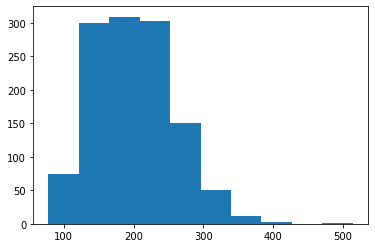

In [ ]:
# plot histogram of passage length
y = [pair[1] for pair in [(i,len(sentence.split(' '))) for i,sentence in enumerate(sentence_df.sentence.values)]] ##word length
plt.hist(y)

In [ ]:
# label dict for SOBI model
labels_to_ids_sentence = {'B':0,'I':1,'S':2, 'O':3,'SpecialToken':-100} #'O':3,
ids_to_labels_sentence = {0:'B',1:'I',2:'S', 3: 'O', -100:'SpecialToken'} # 3: 'O',

## SequenceClassification Model

### Preparation

In [ ]:
# load pretrained model with new output length
model_seq = AutoModelForTokenClassification.from_pretrained('allenai/scibert_scivocab_cased', num_labels=len(ids_to_labels_sentence.items()))

Some weights of the model checkpoint at allenai/scibert_scivocab_cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initial

In [ ]:
#@title create dataset class
class dataset_seq(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
  def __getitem__(self, index):
        # step 1: get the sentence and word labels 
        text = self.data.sentence[index].split(' ')
        sentence_label = self.data.labels[index]

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)


        encoding = self.tokenizer(text,
                             is_split_into_words=True, 
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)        
       

        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [labels_to_ids_sentence[label] for label in sentence_label] 

        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
       
        return item

  def __len__(self):
        return self.len

In [ ]:
# train test split
train_size = 0.8
train_dataset_seq = sentence_df.sample(frac=train_size,random_state=200)
test_dataset_seq = sentence_df.drop(train_dataset_seq.index).reset_index(drop=True)
train_dataset_seq = train_dataset_seq.reset_index(drop=True)

print("FULL Dataset sequence: {}".format(sentence_df.shape))
print("TRAIN Dataset sequence: {}".format(train_dataset_seq.shape))
print("TEST Dataset sequence: {}".format(test_dataset_seq.shape))

training_set = dataset_seq(train_dataset_seq, tokenizer, MAX_LEN)
testing_set = dataset_seq(test_dataset_seq, tokenizer, MAX_LEN)

FULL Dataset sequence: (1201, 2)
TRAIN Dataset sequence: (961, 2)
TEST Dataset sequence: (240, 2)


In [ ]:
# create dataloader
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
# move to GPU
model_seq.to(device)

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31116, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

Sample input

In [ ]:
inputs = training_set[5]
input_ids = inputs["input_ids"].unsqueeze(0)
attention_mask = inputs["attention_mask"].unsqueeze(0)
labels = inputs["labels"].unsqueeze(0)

input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
labels = labels.to(device)

outputs = model_seq(input_ids, attention_mask=attention_mask, labels = labels)

print(f'loss: {outputs[0]}, logit {outputs[1]}')

loss: 1.6534124612808228, logit tensor([[[-0.0768, -0.7454,  0.1025, -0.0455, -0.2533],
         [-0.0038, -0.7652,  0.0726, -0.2042, -0.1944],
         [-0.5929, -0.9600,  0.9215, -0.6778,  0.1617],
         ...,
         [-0.7652, -0.8520,  0.5033,  0.1598,  0.0505],
         [-0.3632, -0.2640,  0.1006, -0.0555, -0.1786],
         [-0.3974, -0.2953,  0.1300,  0.2542, -0.4024]]], device='cuda:0',
       grad_fn=<AddBackward0>)


In [ ]:
# random prediction logit
-math.log(1/5)

1.6094379124341003

### Training
Thực hiện cell này để train lại model

In [ ]:
#@ Optimizer
LEARNING_RATE = 1e-5 #@param {type:"number"}
optimizer = 'adam' #@param{type:"string"}
optimizer = torch.optim.Adam(params=model_seq.parameters(), lr=LEARNING_RATE)

In [ ]:
#@title define traning function
# Defining the training function on the 80% of the dataset for tuning the bert model
def train(epoch):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model_seq.train()
    
    for idx, batch in enumerate(training_loader):
  
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        outputs = model_seq(input_ids=ids, attention_mask=mask, labels=labels)
        
        tr_logits = outputs[1]
        loss = outputs[0]

        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 10==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss at training step {idx}: {loss_step}")
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model_seq.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != 3 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
 
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model_seq.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [ ]:
#@title train
EPOCHS = 5 #@param {type:"integer"}
for epoch in range(EPOCHS):
    print(f"Training epoch: {epoch + 1}")
    train(epoch)

Training epoch: 1
Training loss at training step 0: 1.6772611141204834
Training loss at training step 10: 0.9580720663070679
Training loss at training step 20: 0.803298647914614
Training loss at training step 30: 0.7179690734032662
Training loss at training step 40: 0.657503357747706
Training loss at training step 50: 0.620368700985815
Training loss at training step 60: 0.586518301338446
Training loss at training step 70: 0.5578768257523926
Training loss at training step 80: 0.5276004600304144
Training loss at training step 90: 0.5009553082041688
Training loss at training step 100: 0.47036667441082475
Training loss at training step 110: 0.44559639537925116
Training loss at training step 120: 0.4217986191107222
Training loss epoch: 0.4217986191107222
Training accuracy epoch: 0.039534845849854804
Training epoch: 2
Training loss at training step 0: 0.24017764627933502
Training loss at training step 10: 0.15277546813542192
Training loss at training step 20: 0.14668730930203483
Training los

KeyboardInterrupt: ignored

In [ ]:
#@title evaluation
def valid(model, testing_loader):
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            outputs = model(input_ids=ids, attention_mask=mask, labels=labels)
            
            loss = outputs[0]
            eval_logits = outputs[1]
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            if idx % 100==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")
              
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [ids_to_labels_sentence[id.item()] for id in eval_labels]
    predictions = [ids_to_labels_sentence[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions
labels, predictions = valid(model_seq, testing_loader)

Validation loss per 100 evaluation steps: 0.020887425169348717
Validation Loss: 0.10246436722227373
Validation Accuracy: 0.9715505895984153


### Save model

In [ ]:
directory = "./model/newsentencemodel" # chọn tên model save lại


if not os.path.exists(directory):
    os.makedirs(directory)

# save vocabulary of the tokenizer
tokenizer.save_vocabulary(directory)
# save the model weights and its configuration file
model_seq.save_pretrained(directory)
print('All files saved')

All files saved


# Model inference
Thực hiện trên model cũ hoặc model mới train

### Load model

In [ ]:
#@title Reload functions
#@markdown (use when not train, infer old model)
def ExtractSentenceWithAcronym(original_passage):
  # this function will return new passage with annotated sentences
  passage = deepcopy(original_passage)
  text = passage.text
  # extract annotation
  sf_offset_stack_unsort = dict()
  for i, annotation in enumerate(passage.annotations):
    if i%2 == 0:
      sf_offset_stack_unsort[passage.annotations[i].total_span.offset] = i #extract the SF offset only
  offsetList = [offset for offset,i in sf_offset_stack_unsort.items()]
  
  sf_offset_stack = []
  while offsetList:

    minoffset = min(offsetList)
    idx = sf_offset_stack_unsort[minoffset]
    sf_offset_stack.append([idx, passage.annotations[idx].total_span.offset])
    offsetList.remove(minoffset)

    # sentence extraction
  rawSentenceList = text.split('. ') #split passage to list of sentence
  
  cased_alphabet = 'ABCEDEFGHIJKLMNOPQRSTUVWXYZ'
  sentenceList = []
  for i, raw_sentence in enumerate(rawSentenceList):
    if raw_sentence[-1] != '.':
      raw_sentence += '.' # add . if sentence doesn't have
    if raw_sentence[0] in cased_alphabet and len(raw_sentence) >10:
      sentenceList.append(raw_sentence)
    else:
      if sentenceList:
        sentenceList[-1] += ' ' + raw_sentence
      else:
        sentenceList.append(raw_sentence)

  # add annotation for sentence
  pointer = 0
  for sentence in sentenceList:
    bioc_sentence = bioc.bioc.BioCSentence() 
    bioc_sentence.text = sentence
    while len(sf_offset_stack):
      if sf_offset_stack[0][1] < pointer + len(sentence):
        sf = sf_offset_stack.pop(0)
        bioc_sentence.annotations.append(passage.annotations[sf[0]]) # get SF annotation
        bioc_sentence.annotations.append(passage.annotations[sf[0]+1]) # get LF annotation
        bioc_sentence.annotations[-2].locations[0].offset -= pointer # change SF offset to sentence (originally was offset passage)
        bioc_sentence.annotations[-1].locations[0].offset -= pointer # change LF offset to sentence (originally was offset passage)  
      else:
        break
    bioc_sentence.offset = pointer
    pointer += len(sentence) + 1 # move pointer to next sentence, 1 for .
    passage.add_sentence(bioc_sentence) # add sentence to passage
      
  return passage


def PredictToken(text):
  text = text.split(' ')
  inputs = tokenizer(text,
                    is_split_into_words=True,
                    return_offsets_mapping=True, 
                    padding='max_length', 
                    truncation=True, 
                    max_length=512,
                    return_tensors="pt")

  # move to gpu
  ids = inputs["input_ids"].to(device)
  mask = inputs["attention_mask"].to(device)
  # forward pass
  outputs = model_seq(ids, attention_mask=mask)
  logits = outputs[0]

  active_logits = logits.view(-1, model_seq.num_labels) # shape (batch_size * seq_len, num_labels)
  flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size*seq_len,) - predictions at the token level

  tokens = tokenizer.convert_ids_to_tokens(ids.squeeze().tolist())
  token_predictions = [ids_to_labels_sentence[i] for i in flattened_predictions.cpu().numpy()]
  wp_preds = list(zip(tokens, token_predictions)) # list of tuples. Each tuple = (wordpiece, prediction)

  prediction = []
  for token_pred, mapping in zip(wp_preds, inputs["offset_mapping"].squeeze().tolist()):
    #only predictions on first word pieces are important
    if mapping[0] == 0 and mapping[1] != 0:
      prediction.append(token_pred[1])
    else:
      continue
  return prediction

def PredictSentenceWithABBR(text):
  text_split = text.split(' ')
  prediction = PredictToken(text)
  sentenceList = []
  for i in range(len(prediction)-1):
    if prediction[i] == 'B':
      for j in range(i+1, len(prediction)):
        if prediction[j] in 'BS':
          sentence = ' '.join(text_split[i:j])
          if j-i>4: # at least 5 words per sentence
            sentenceList.append(sentence)
          break
        elif j == len(prediction)-1:
          sentence = ' '.join(text_split[i:])
          sentenceList.append(sentence)
          break               
  return sentenceList

def PredictBiocSentenceWithABBR(passage):
  sentences_from_passage = ExtractSentenceWithAcronym(passage).sentences
  sentenceList = PredictSentenceWithABBR(passage.text)
  biocSentenceList = []
  for sentence in sentences_from_passage:
    for i, annotation in enumerate(sentence.annotations):
      if i%2 == 0 :
        haveSF = sentence.annotations[0].text in ' '.join(PredictSentenceWithABBR(passage.text))

        haveLF = []
        for word in sentence.annotations[1].text.split(' '):
          if word in ' '.join(PredictSentenceWithABBR(passage.text)):
            haveLF.append(1)
          else:
            haveLF.append(0)
        haveLF = bool(np.prod(haveLF))
        if haveSF and haveLF:
          if sentence not in biocSentenceList:
            biocSentenceList.append(sentence)
    if not sentence.annotations:
      if sentence.text in sentenceList:
        biocSentenceList.append(sentence)
      else:
        for predicted_sentence in sentenceList:
          if predicted_sentence in sentence.text:
            biocSentenceList.append(sentence)
  return biocSentenceList

In [ ]:
directory = "./model/newsentencemodel" # chọn model
tokenizer = transformers.AutoTokenizer.from_pretrained(directory, local_files_only=True)
model_seq = transformers.AutoModelForTokenClassification.from_pretrained(directory, local_files_only=True)
model_seq.to(device)

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31116, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

### check difference of SentenceModel

In [ ]:
#@title Create dataframe
difference = []
i = 0
for document in gold_raw.documents:
  passage = document.passages[0]
  count_true = len([sentence for sentence in ExtractSentenceWithAcronym(passage).sentences if sentence.annotations])
  count_predict = len(PredictBiocSentenceWithABBR(passage))

  difference.append(count_true - count_predict)

  if i%50 == 0:
    print(f'process passage {i}')
  i += 1

process passage 0
process passage 50
process passage 100
process passage 150
process passage 200
process passage 250
process passage 300
process passage 350
process passage 400
process passage 450
process passage 500
process passage 550
process passage 600
process passage 650
process passage 700
process passage 750
process passage 800
process passage 850
process passage 900
process passage 950
process passage 1000
process passage 1050
process passage 1100
process passage 1150
process passage 1200


In [ ]:
#@title Create wrong prediction count table
table = []
for i,diff in enumerate(difference):
  if diff != 0:
    table.append((i,diff))

[(27, 1),
 (51, 2),
 (59, 2),
 (61, 1),
 (81, 1),
 (97, 1),
 (110, 1),
 (247, 1),
 (269, 1),
 (275, 1),
 (287, 1),
 (333, 1),
 (351, 1),
 (358, 1),
 (365, 1),
 (367, 1),
 (457, 1),
 (483, 1),
 (512, 1),
 (538, 1),
 (550, 1),
 (559, 1),
 (601, 1),
 (630, 1),
 (638, 1),
 (642, 1),
 (652, 2),
 (698, 1),
 (709, 2),
 (728, 1),
 (729, 1),
 (758, 1),
 (761, 1),
 (771, 1),
 (796, 1),
 (799, 1),
 (800, 1),
 (835, 1),
 (862, 1),
 (895, 1),
 (903, 1),
 (910, 1),
 (947, 2),
 (960, 1),
 (973, 1),
 (981, 1),
 (1004, 1),
 (1024, 1),
 (1091, 1),
 (1099, 1),
 (1110, 1),
 (1115, 1),
 (1138, 1),
 (1186, 1),
 (1190, 1),
 (1200, 1)]

In [ ]:
#@title Print false positive cases
table = []
for i,diff in enumerate(difference):
  if diff < 0:
    table.append((i,diff))
print(f'FP: {len(table)}')
for pair in table:
  idx = pair[0]
  passage = gold_raw.documents[idx].passages[0]
  for sentence in PredictBiocSentenceWithABBR(passage):
    if not sentence.annotations:
      print(sentence.text)

FP: 19
Although cell surface receptors for the Fc region of IgA (Fc alpha R) have been implicated in a variety of immune effector mechanisms, the molecular features of Fc alpha R remain only marginally characterized.
Primary structure of the human melanoma-associated antigen p97 (melanotransferrin) deduced from the mRNA sequence. p97 is a cell-surface glycoprotein that is present in most human melanomas but only in trace amounts in normal adult tissues.
A full-length 1966-base pair clone of the human class IV alcohol dehydrogenase (sigma-ADH) was isolated from a human stomach cDNA library.
There are important amino acid differences in the alcohol-binding site between the human class IV (sigma) and human class I (beta) alcohol dehydrogenases that appear to explain the high catalytic efficiency for all-trans-retinol, the high kcat for ethanol, and the low catalytic efficiency for secondary alcohols of sigma-ADH relative to beta 1-ADH.
The beta-subunit of the high-affinity IgE receptor (F

In [ ]:
#@title Print false negative cases
table = []
for i,diff in enumerate(difference):
  if diff > 0:
    table.append((i,diff))
table
print(f'FN: {len(table)}')

for pair in table:
  idx = pair[0]
  passage = gold_raw.documents[idx].passages[0]
  truesentence = [sentence for sentence in ExtractSentenceWithAcronym(passage).sentences if sentence.annotations]
  prediction = [sentence.text for sentence in PredictBiocSentenceWithABBR(passage)]

  for sentence in truesentence:
  
    if sentence.text not in prediction and sentence.annotations:
      print(sentence.text)

FN: 56
In comparison, homologues of the Rad23 proteins (hHR23) and the hXPC protein are involved in the recognition of damaged bases in global genome repair, a subset of nucleotide excision repair.
AMP-activated protein kinase (AMPK) is viewed as an energy sensor that acts to modulate glucose uptake and fatty acid oxidation in skeletal muscle.
Injections of 5-aminoimidazole-4-carboxamide 1-beta-d-ribonucleoside (AICAR) were used to activate AMPK in male rats.
The Ah (dioxin) receptor binds a number of widely disseminated environmental pollutants, including 2,3,7,8-tetrachlorodibenzo-p-dioxin (TCDD) and polycyclic aromatic hydrocarbons, and mediates their carcinogenic effects.
The ligand-bound receptor activates Cyp 1a1 gene transcription through interaction with specific DNA sequences, termed xenobiotic responsive elements (XREs).
A cDNA encoding UDP-GlcNAc:Gal beta 1-3GalNAc-R (GlcNAc to GalNAc) beta 1-6GlcNAc transferase (EC 2.4.1.102), which forms critical branches in O-glycans, has

## Test on AB3P corpus

In [ ]:
# change annotations offset:
for document in ab3p.documents:
  for passage in document.passages:
    passage_offset = passage.offset
    for annotation in passage.annotations:
      annotation.locations[0].offset -= passage_offset
print('substracted passage offset')

substracted passage offset


In [ ]:
#@title create data frame
sentence_test_corpus = []
tag_test_corpus = []
tag_prediction = []
id_test_corpus = []

i = 0


for document in ab3p.documents:

  passage = document.passages[1]
  new_passage = ExtractSentenceWithAcronym(passage)
  predictionList = PredictSentenceWithABBR(passage.text)
  for sentence in new_passage.sentences:
    # get sentence
    sentence_test_corpus.append(sentence.text)
    # get id
    id_test_corpus.append(i)
    # get truth

    if sentence.annotations:
      tag_test_corpus.append(True)

    else:
      tag_test_corpus.append(False)

    #get prediction
    tag_prediction.append(False)
    for predicted_sentence in predictionList:
      if sentence.text in predicted_sentence or predicted_sentence in sentence.text:
        tag_prediction[-1] = True
  if i%50 == 0:
    print(f'Process passage {i}')          
      
  i+=1
contigency_df = pd.DataFrame({'sentence':sentence_test_corpus,'truth':tag_test_corpus,'prediction':tag_prediction, 'id':id_test_corpus})

Process passage 0
Process passage 50
Process passage 100
Process passage 150
Process passage 200
Process passage 250
Process passage 300
Process passage 350
Process passage 400
Process passage 450
Process passage 500
Process passage 550
Process passage 600
Process passage 650
Process passage 700
Process passage 750
Process passage 800
Process passage 850
Process passage 900
Process passage 950
Process passage 1000
Process passage 1050
Process passage 1100
Process passage 1150
Process passage 1200


In [ ]:
contigency_df

,sentence,truth,prediction,id
0,OBJECTIVE: To generate a classification of met...,False,False,0
1,METHODS: Multiple search strategies were emplo...,False,False,0
2,RESULTS: All methods available were classified...,False,False,0
3,"The first method group, impute or adjust for m...",False,False,0
4,"The second group, correct imperfect reference ...",False,False,0
...,...,...,...,...
9212,Mutation of S383 and S387 abolished the phosph...,False,False,1249
9213,These results were confirmed by use of phospho...,False,False,1249
9214,"Furthermore, the ability to correct FA-G mutan...",False,False,1249
9215,S387A mutant abolished FANCG fusion protein ph...,False,False,1249


In [ ]:
#@ calculate TP, TN, FN, FP
TP = 0
TN = 0
FN = 0
FP = 0
n = contigency_df.shape[0]
for i in range(n):
  if contigency_df.truth[i] == True and contigency_df.prediction[i] == True:
    TP += 1
  elif contigency_df.truth[i] == False and contigency_df.prediction[i] == False:
    TN += 1
  elif contigency_df.truth[i] == True and contigency_df.prediction[i] == False:
    FN += 1
  elif contigency_df.truth[i] == False and contigency_df.prediction[i] == True:
    FP += 1
print(f'True Positive:{TP}\n False Positve:{FP}\n True Negative:{TN}\n False Negative:{FN}\n')

True Positive:762
 False Positve:32
 True Negative:8321
 False Negative:102



In [ ]:
#@ metric
accuracy = (TP+TN)/(TP+TN+FN+FP)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
print(f'overall accuracy: {accuracy} \n precision: {precision} \n recall: {recall}')

overall accuracy: 0.9854616469567105 
 precision: 0.9596977329974811 
 recall: 0.8819444444444444


## Predict new sentence

In [ ]:
input = input()

In [ ]:
PredictSentenceWithABBR(input)

In [ ]:
for i in range(len(input.split())):
  print(input.split()[i],PredictToken(input)[i])

Parathyroid S
hormone-regulated O
production O
of O
stem O
cell O
factor O
in O
human O
osteoblasts O
and O
osteoblast-like O
cells. O
We B
investigated I
stem I
cell I
factor I
(SCF) I
expression I
in I
osteoblasts I
because I
mast I
cells, I
which I
occur I
ectopically I
in I
hyperparathyroid I
bone, I
are I
induced I
by I
SCF. I
Nontransformed S
osteoblasts O
and O
Saos2 O
or O
MG63 O
cells O
expressed O
SCF O
in O
response O
to O
PTH. O
Western S
analysis O
showed O
only O
large, O
cell-associated O
isoforms, O
Mrs O
approximately O
40-48 O
kD. O
Transfection S
of O
MG63 O
cells O
with O
plasmids O
expressing O
antisense O
SCF O
mRNA O
eliminated O
immunoreactive O
SCF. O
Sequencing S
osteoblast O
SCF O
cDNAs O
showed O
that O
exon O
6 O
was O
omitted. O
mRNAs S
without O
exon O
6 O
produce O
membrane-associated O
SCF O
isoforms O
in O
rodents, O
suggesting O
that O
human O
SCFs O
are O
processed O
similarly. O
The S
major O
osteoblastic O
SCF O
mRNA, O
approximately O
5 O
kB, O
wa